In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 50
latent_dim = 20
num_classes = 10

In [4]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.08MB/s]


In [7]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 7x7 -> 3x3
            nn.ReLU(),
        )

        # Calculate flattened size after conv layers
        self.conv_output_size = 128 * 3 * 3

        # Encoder fully connected layers
        self.encoder_fc = nn.Sequential(
            nn.Linear(self.conv_output_size + num_classes, 256),
            nn.ReLU(),
        )

        # Latent space
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, self.conv_output_size),
            nn.ReLU(),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 0),  # 3x3 -> 7x7 (Output size = (3-1)*2 - 2*0 + 3 = 4+3=7)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 7x7 -> 14x14 (Output size = (7-1)*2 - 2*1 + 4 = 12-2+4=14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),    # 14x14 -> 28x28 (Output size = (14-1)*2 - 2*1 + 4 = 26-2+4=28)
            nn.Sigmoid(),
        )

    def encode(self, x, c):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, c], dim=1)
        x = self.encoder_fc(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z = torch.cat([z, c], dim=1)
        x = self.decoder_fc(z)
        x = x.view(x.size(0), 128, 3, 3)
        x = self.decoder_conv(x)
        return x

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train_model():
    model = ConditionalVAE(latent_dim=latent_dim, num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (data, labels) in enumerate(progress_bar):
            data = data.to(device)
            labels = labels.to(device)

            # One-hot encode labels
            labels_onehot = F.one_hot(labels, num_classes=num_classes).float()

            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data, labels_onehot)
            loss = loss_function(recon_batch, data, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item() / len(data)})

        avg_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

        # Save model checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f'cvae_epoch_{epoch+1}.pth')

    # Save final model
    torch.save(model.state_dict(), 'cvae_final.pth')
    return model, train_losses

def generate_digits(model, digit, num_samples=5):
    """Generate specified number of digit samples"""
    model.eval()
    with torch.no_grad():
        # Create one-hot encoded labels
        labels = torch.tensor([digit] * num_samples).to(device)
        labels_onehot = F.one_hot(labels, num_classes=num_classes).float()

        # Sample from latent space
        z = torch.randn(num_samples, latent_dim).to(device)

        # Generate images
        generated = model.decode(z, labels_onehot)

    return generated.cpu()

def visualize_generation(model, digit):
    """Visualize generated digits"""
    generated = generate_digits(model, digit, 10)

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated[i].squeeze(), cmap='gray')
        ax.set_title(f'Generated {digit}')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'generated_digit_{digit}.png')
    plt.show()

def main():
    print("Starting CVAE training for MNIST digit generation...")

    # Train the model
    model, losses = train_model()

    # Generate samples for each digit
    print("\nGenerating sample digits...")
    for digit in range(10):
        visualize_generation(model, digit)

    print("Training completed! Model saved as 'cvae_final.pth'")

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('training_loss.png')
    plt.show()

Starting CVAE training for MNIST digit generation...


Epoch 1/50: 100%|██████████| 469/469 [00:11<00:00, 41.81it/s, Loss=132]


Epoch 1, Average Loss: 180.3369


Epoch 2/50: 100%|██████████| 469/469 [00:10<00:00, 43.45it/s, Loss=115]


Epoch 2, Average Loss: 123.7137


Epoch 3/50: 100%|██████████| 469/469 [00:11<00:00, 41.38it/s, Loss=98.7]


Epoch 3, Average Loss: 110.6494


Epoch 4/50: 100%|██████████| 469/469 [00:10<00:00, 42.86it/s, Loss=99.5]


Epoch 4, Average Loss: 105.7136


Epoch 5/50: 100%|██████████| 469/469 [00:10<00:00, 42.83it/s, Loss=99.6]


Epoch 5, Average Loss: 103.3398


Epoch 6/50: 100%|██████████| 469/469 [00:11<00:00, 41.42it/s, Loss=104]


Epoch 6, Average Loss: 101.4912


Epoch 7/50: 100%|██████████| 469/469 [00:10<00:00, 43.64it/s, Loss=101]


Epoch 7, Average Loss: 100.0974


Epoch 8/50: 100%|██████████| 469/469 [00:10<00:00, 43.96it/s, Loss=103]


Epoch 8, Average Loss: 98.9880


Epoch 9/50: 100%|██████████| 469/469 [00:10<00:00, 42.90it/s, Loss=90.6]


Epoch 9, Average Loss: 98.1141


Epoch 10/50: 100%|██████████| 469/469 [00:10<00:00, 42.93it/s, Loss=103]


Epoch 10, Average Loss: 97.4605


Epoch 11/50: 100%|██████████| 469/469 [00:10<00:00, 42.67it/s, Loss=94.2]


Epoch 11, Average Loss: 96.8800


Epoch 12/50: 100%|██████████| 469/469 [00:10<00:00, 43.09it/s, Loss=96.5]


Epoch 12, Average Loss: 96.3953


Epoch 13/50: 100%|██████████| 469/469 [00:10<00:00, 43.49it/s, Loss=93]


Epoch 13, Average Loss: 95.8932


Epoch 14/50: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s, Loss=92.2]


Epoch 14, Average Loss: 95.6281


Epoch 15/50: 100%|██████████| 469/469 [00:10<00:00, 43.27it/s, Loss=95.2]


Epoch 15, Average Loss: 95.2798


Epoch 16/50: 100%|██████████| 469/469 [00:10<00:00, 43.79it/s, Loss=97.9]


Epoch 16, Average Loss: 94.9704


Epoch 17/50: 100%|██████████| 469/469 [00:10<00:00, 44.84it/s, Loss=103]


Epoch 17, Average Loss: 94.6887


Epoch 18/50: 100%|██████████| 469/469 [00:10<00:00, 43.74it/s, Loss=91.2]


Epoch 18, Average Loss: 94.3995


Epoch 19/50: 100%|██████████| 469/469 [00:10<00:00, 43.22it/s, Loss=95.4]


Epoch 19, Average Loss: 93.9837


Epoch 20/50: 100%|██████████| 469/469 [00:10<00:00, 43.24it/s, Loss=93.8]


Epoch 20, Average Loss: 93.6746


Epoch 21/50: 100%|██████████| 469/469 [00:10<00:00, 43.36it/s, Loss=95.9]


Epoch 21, Average Loss: 93.3572


Epoch 22/50: 100%|██████████| 469/469 [00:10<00:00, 43.48it/s, Loss=90.2]


Epoch 22, Average Loss: 93.1529


Epoch 23/50: 100%|██████████| 469/469 [00:10<00:00, 43.28it/s, Loss=91]


Epoch 23, Average Loss: 92.8738


Epoch 24/50: 100%|██████████| 469/469 [00:10<00:00, 43.38it/s, Loss=91.9]


Epoch 24, Average Loss: 92.7620


Epoch 25/50: 100%|██████████| 469/469 [00:10<00:00, 43.77it/s, Loss=94.1]


Epoch 25, Average Loss: 92.5654


Epoch 26/50: 100%|██████████| 469/469 [00:10<00:00, 44.70it/s, Loss=95.2]


Epoch 26, Average Loss: 92.4431


Epoch 27/50: 100%|██████████| 469/469 [00:10<00:00, 43.62it/s, Loss=92.7]


Epoch 27, Average Loss: 92.3063


Epoch 28/50: 100%|██████████| 469/469 [00:10<00:00, 43.24it/s, Loss=89]


Epoch 28, Average Loss: 92.1439


Epoch 29/50: 100%|██████████| 469/469 [00:10<00:00, 43.32it/s, Loss=94]


Epoch 29, Average Loss: 91.9692


Epoch 30/50: 100%|██████████| 469/469 [00:10<00:00, 43.42it/s, Loss=86.8]


Epoch 30, Average Loss: 91.9050


Epoch 31/50: 100%|██████████| 469/469 [00:10<00:00, 43.49it/s, Loss=87.6]


Epoch 31, Average Loss: 91.7654


Epoch 32/50: 100%|██████████| 469/469 [00:10<00:00, 43.35it/s, Loss=95.8]


Epoch 32, Average Loss: 91.6655


Epoch 33/50: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s, Loss=86.1]


Epoch 33, Average Loss: 91.5803


Epoch 34/50: 100%|██████████| 469/469 [00:10<00:00, 43.84it/s, Loss=93.1]


Epoch 34, Average Loss: 91.4469


Epoch 35/50: 100%|██████████| 469/469 [00:10<00:00, 43.96it/s, Loss=93.3]


Epoch 35, Average Loss: 91.3504


Epoch 36/50: 100%|██████████| 469/469 [00:10<00:00, 43.00it/s, Loss=91.8]


Epoch 36, Average Loss: 91.2533


Epoch 37/50: 100%|██████████| 469/469 [00:10<00:00, 43.42it/s, Loss=91.9]


Epoch 37, Average Loss: 91.1456


Epoch 38/50: 100%|██████████| 469/469 [00:10<00:00, 43.22it/s, Loss=91.9]


Epoch 38, Average Loss: 91.0869


Epoch 39/50: 100%|██████████| 469/469 [00:10<00:00, 43.11it/s, Loss=93.1]


Epoch 39, Average Loss: 90.9653


Epoch 40/50: 100%|██████████| 469/469 [00:10<00:00, 43.25it/s, Loss=90.2]


Epoch 40, Average Loss: 90.9061


Epoch 41/50: 100%|██████████| 469/469 [00:10<00:00, 43.19it/s, Loss=93.9]


Epoch 41, Average Loss: 90.8375


Epoch 42/50: 100%|██████████| 469/469 [00:10<00:00, 43.18it/s, Loss=91.6]


Epoch 42, Average Loss: 90.7166


Epoch 43/50: 100%|██████████| 469/469 [00:10<00:00, 43.23it/s, Loss=90.9]


Epoch 43, Average Loss: 90.6447


Epoch 44/50: 100%|██████████| 469/469 [00:10<00:00, 44.40it/s, Loss=88]


Epoch 44, Average Loss: 90.6551


Epoch 45/50: 100%|██████████| 469/469 [00:10<00:00, 43.53it/s, Loss=88.6]


Epoch 45, Average Loss: 90.5289


Epoch 46/50: 100%|██████████| 469/469 [00:10<00:00, 43.21it/s, Loss=88.1]


Epoch 46, Average Loss: 90.4731


Epoch 47/50: 100%|██████████| 469/469 [00:10<00:00, 43.30it/s, Loss=91.1]


Epoch 47, Average Loss: 90.3978


Epoch 48/50: 100%|██████████| 469/469 [00:10<00:00, 43.23it/s, Loss=92.4]


Epoch 48, Average Loss: 90.3732


Epoch 49/50: 100%|██████████| 469/469 [00:10<00:00, 43.25it/s, Loss=86]


Epoch 49, Average Loss: 90.3280


Epoch 50/50: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s, Loss=85.9]


Epoch 50, Average Loss: 90.2192

Generating sample digits...


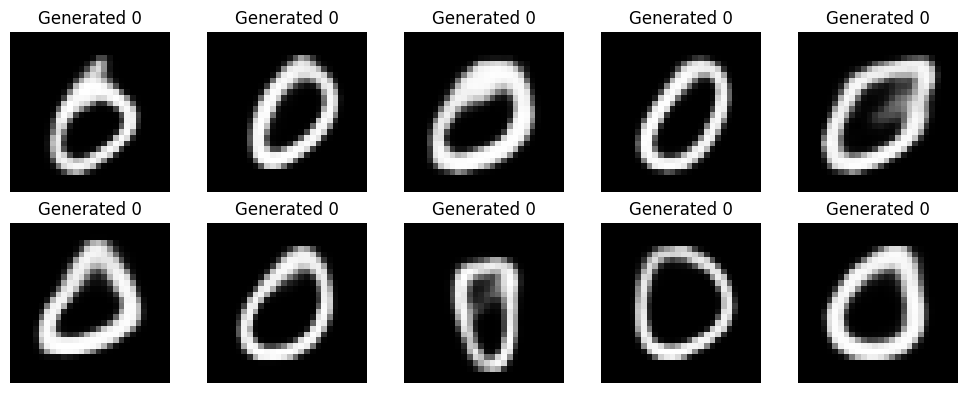

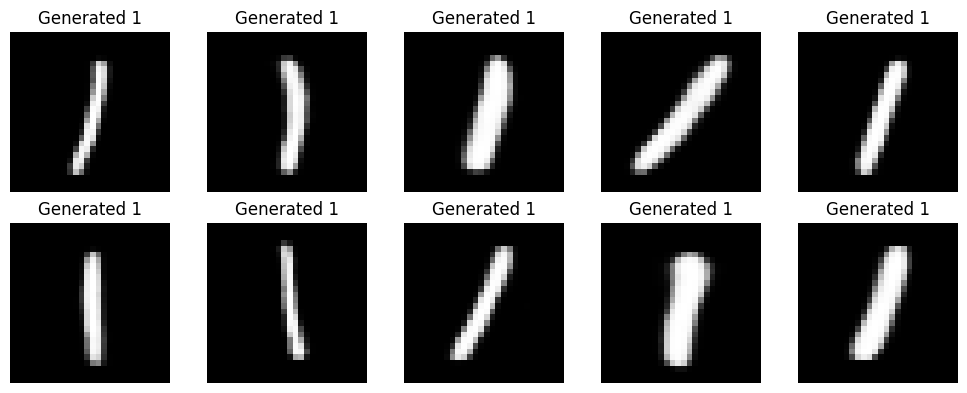

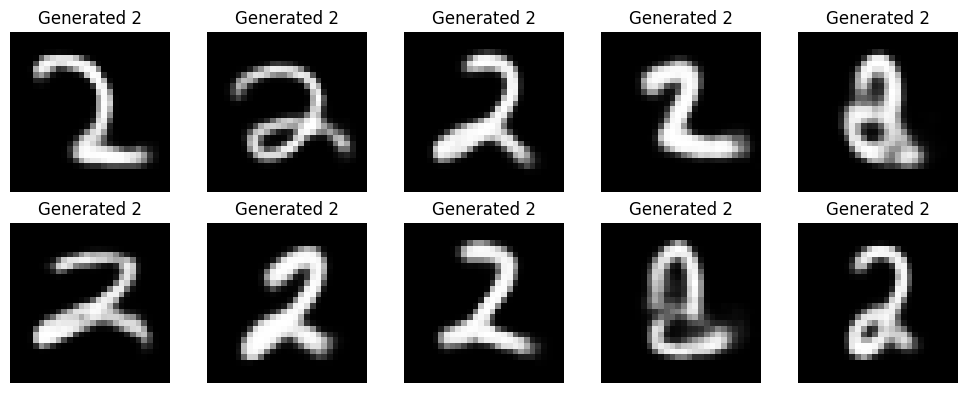

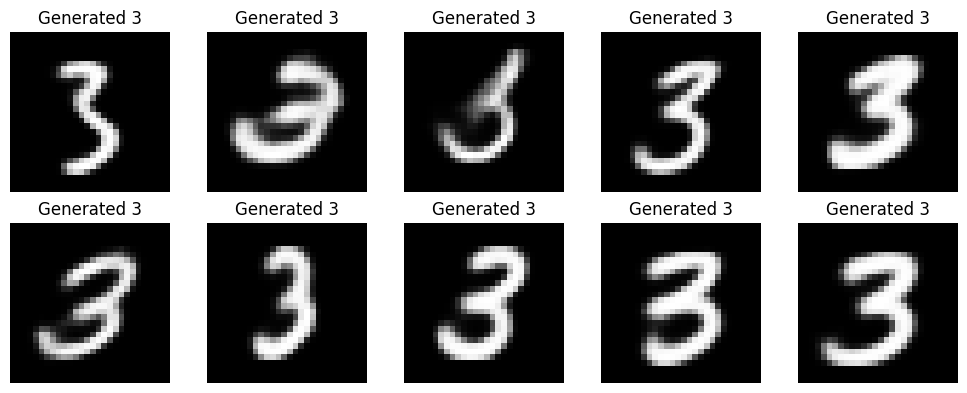

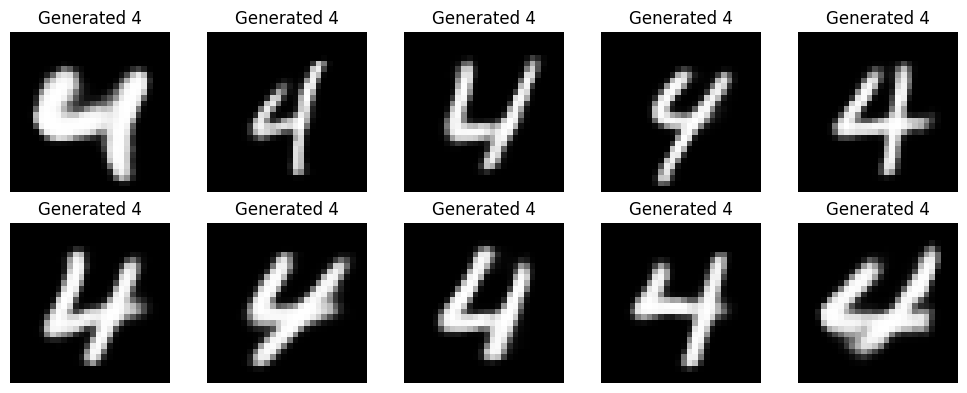

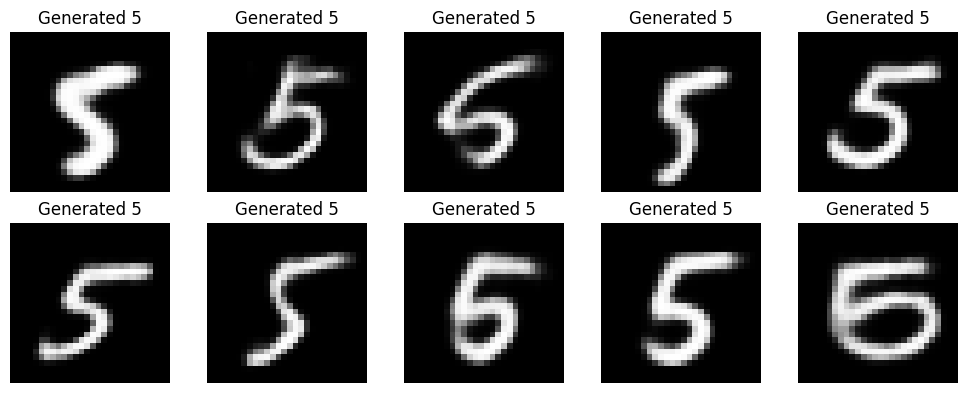

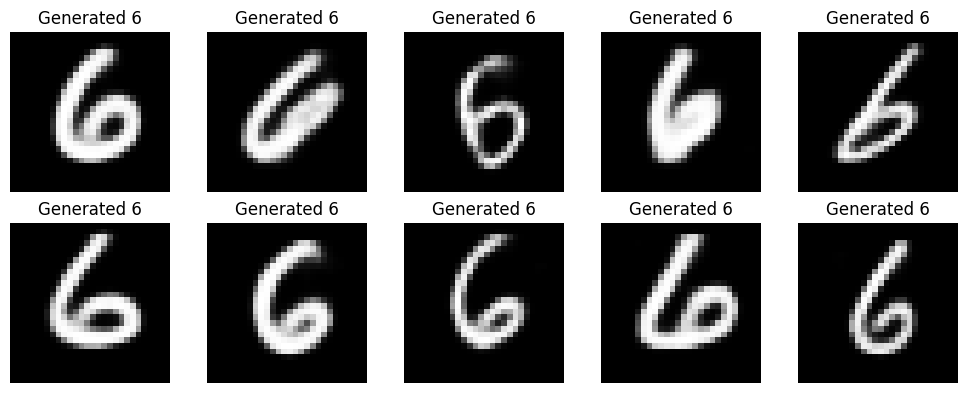

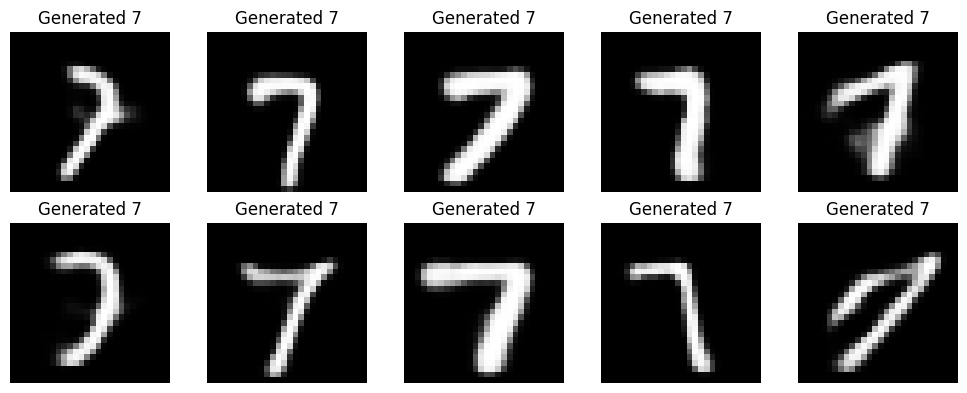

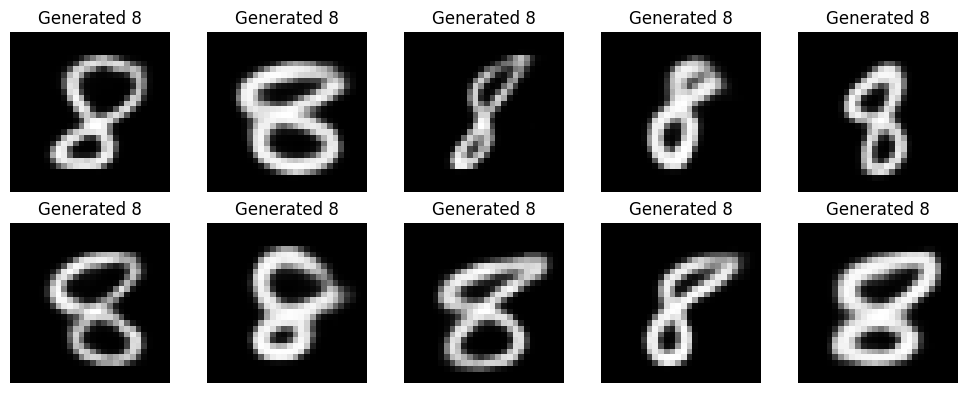

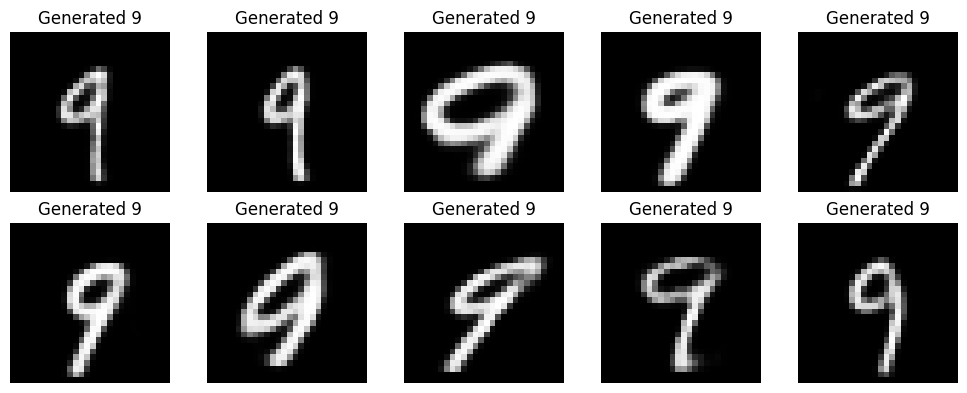

Training completed! Model saved as 'cvae_final.pth'


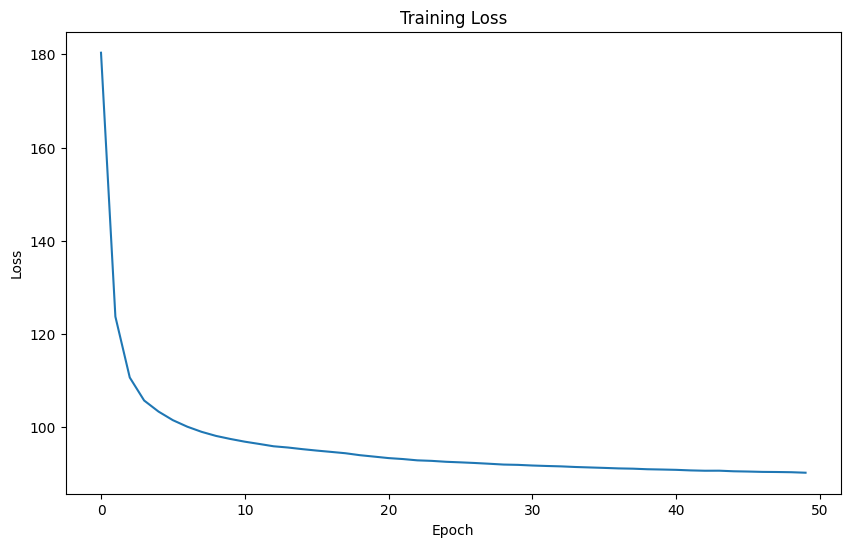

In [8]:
main()

In [10]:

# TARGETED DOWNLOAD FUNCTIONS FOR GOOGLE COLAB
# Copy specific functions as needed

import os, zipfile, glob
from google.colab import files
from datetime import datetime

def download_models():
    """Download only model files (.pth, .pt, .pkl)"""
    model_files = []
    for ext in ['.pth', '.pt', '.pkl', '.h5']:
        model_files.extend(glob.glob(f"*{ext}"))
        model_files.extend(glob.glob(f"**/*{ext}", recursive=True))

    model_files = list(set(model_files))
    if not model_files:
        print("❌ No model files found!")
        return

    print(f"🤖 Found {len(model_files)} model files:")
    for f in model_files:
        size = os.path.getsize(f) / 1024 / 1024
        print(f"  • {f} ({size:.1f} MB)")

    zip_name = f"models_{datetime.now().strftime('%H%M%S')}.zip"
    with zipfile.ZipFile(zip_name, 'w') as z:
        for f in model_files: z.write(f, f)

    files.download(zip_name)
    print(f"✅ Downloaded: {zip_name}")

def download_images():
    """Download only image files"""
    img_files = []
    for ext in ['.png', '.jpg', '.jpeg', '.gif']:
        img_files.extend(glob.glob(f"*{ext}"))
        img_files.extend(glob.glob(f"**/*{ext}", recursive=True))

    img_files = list(set(img_files))
    if not img_files:
        print("❌ No image files found!")
        return

    print(f"🖼️ Found {len(img_files)} image files")
    zip_name = f"images_{datetime.now().strftime('%H%M%S')}.zip"
    with zipfile.ZipFile(zip_name, 'w') as z:
        for f in img_files: z.write(f, f)

    files.download(zip_name)
    print(f"✅ Downloaded: {zip_name}")

def download_specific(filenames):
    """Download specific files by name"""
    existing = [f for f in filenames if os.path.exists(f)]
    missing = [f for f in filenames if not os.path.exists(f)]

    if missing:
        print(f"⚠️ Missing: {missing}")

    if not existing:
        print("❌ No files to download!")
        return

    zip_name = f"specific_{datetime.now().strftime('%H%M%S')}.zip"
    with zipfile.ZipFile(zip_name, 'w') as z:
        for f in existing: z.write(f, f)

    files.download(zip_name)
    print(f"✅ Downloaded: {zip_name}")

# Usage examples:
#download_models()
download_images()
# download_specific(['cvae_final.pth', 'training_loss.png'])


🖼️ Found 11 image files


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: images_094341.zip
